<a href="https://colab.research.google.com/github/ilyayath/house-prices-prediction/blob/main/house_price_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import json


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats.mstats import winsorize
from scipy.stats import f_oneway


from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import optuna

In [ ]:
sns.set_style("whitegrid", {"grid.color": ".85", "grid.linestyle": "--"})
sns.set_context("notebook", font_scale=1.2)

# Loading data

In [ ]:
test_df = pd.read_csv('/content/test.csv')
train_df = pd.read_csv('/content/train.csv')

In [ ]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [ ]:
y = train_df['SalePrice']
train_id = train_df['Id']
test_id = test_df['Id']
train_df.drop(['SalePrice','Id'],axis=1,inplace=True)
test_df.drop(['Id'],axis=1,inplace=True)
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
train_with_saleprice = train_df.copy()
train_with_saleprice['SalePrice'] = y

In [ ]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

# Processing of target variable

In [ ]:
def displot(y):
    sns.displot(
      y,
      kind="kde",
      fill=True,
      rug=True,
      rug_kws={"alpha": 0.7, "height": 0.08, "color": "navy"},
      color="teal",
      alpha=0.5,
      height=6,
      aspect=1.6,
      linewidth=2,
)

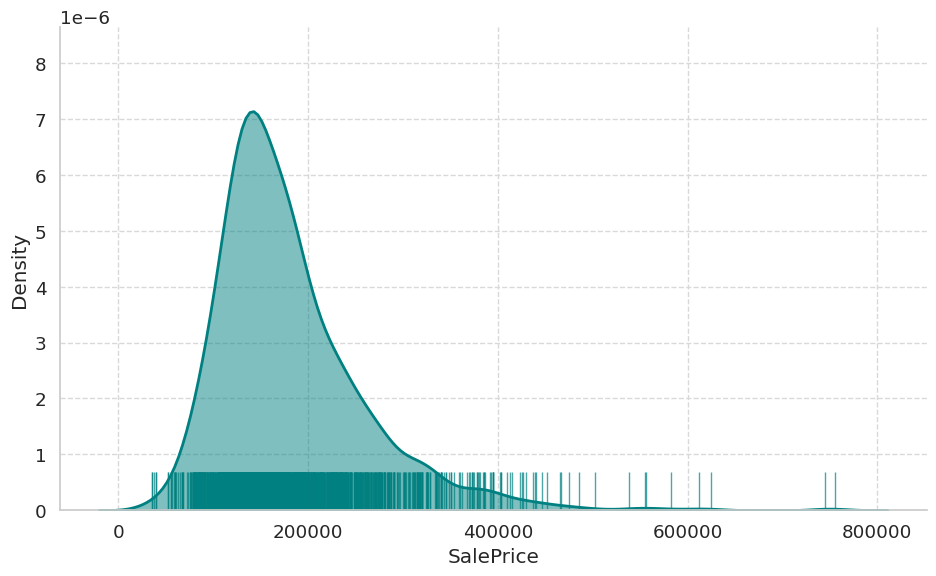

In [ ]:
displot(y)

The SalePrice column has a lognormal distribution, so it is worth logarithming it.

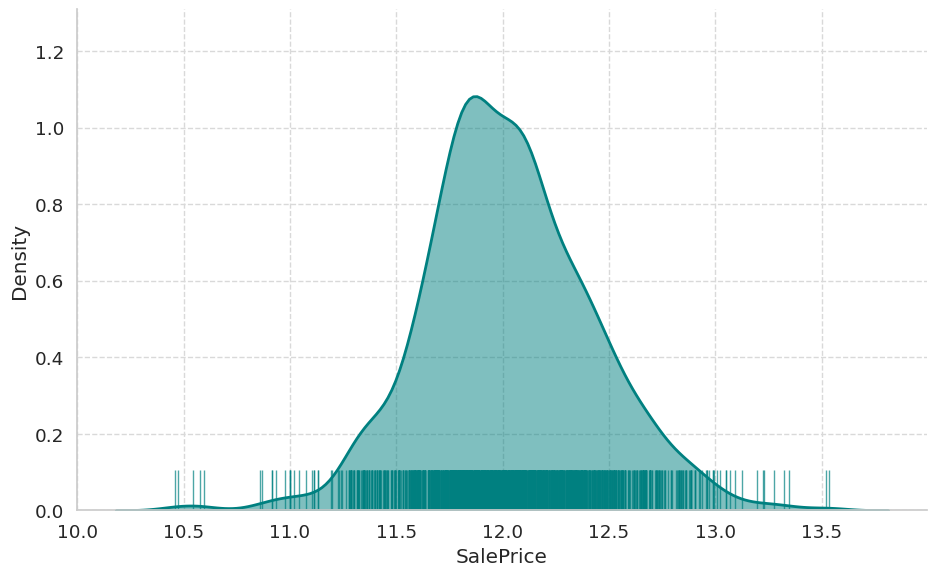

In [ ]:
y = np.log1p(y)
displot(y)

# Analysis of numerical characteristics
We study the distribution of each numerical feature in detail. To do this, we construct combined graphs that include a kernel density curve (KDE), a histogram, and a rug plot. This allows us to identify asymmetry, multimodality, and other features of the data. For visualization stability, we limit the data to the 1st and 99th percentiles.

/tmp/ipython-input-11-3807501114.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


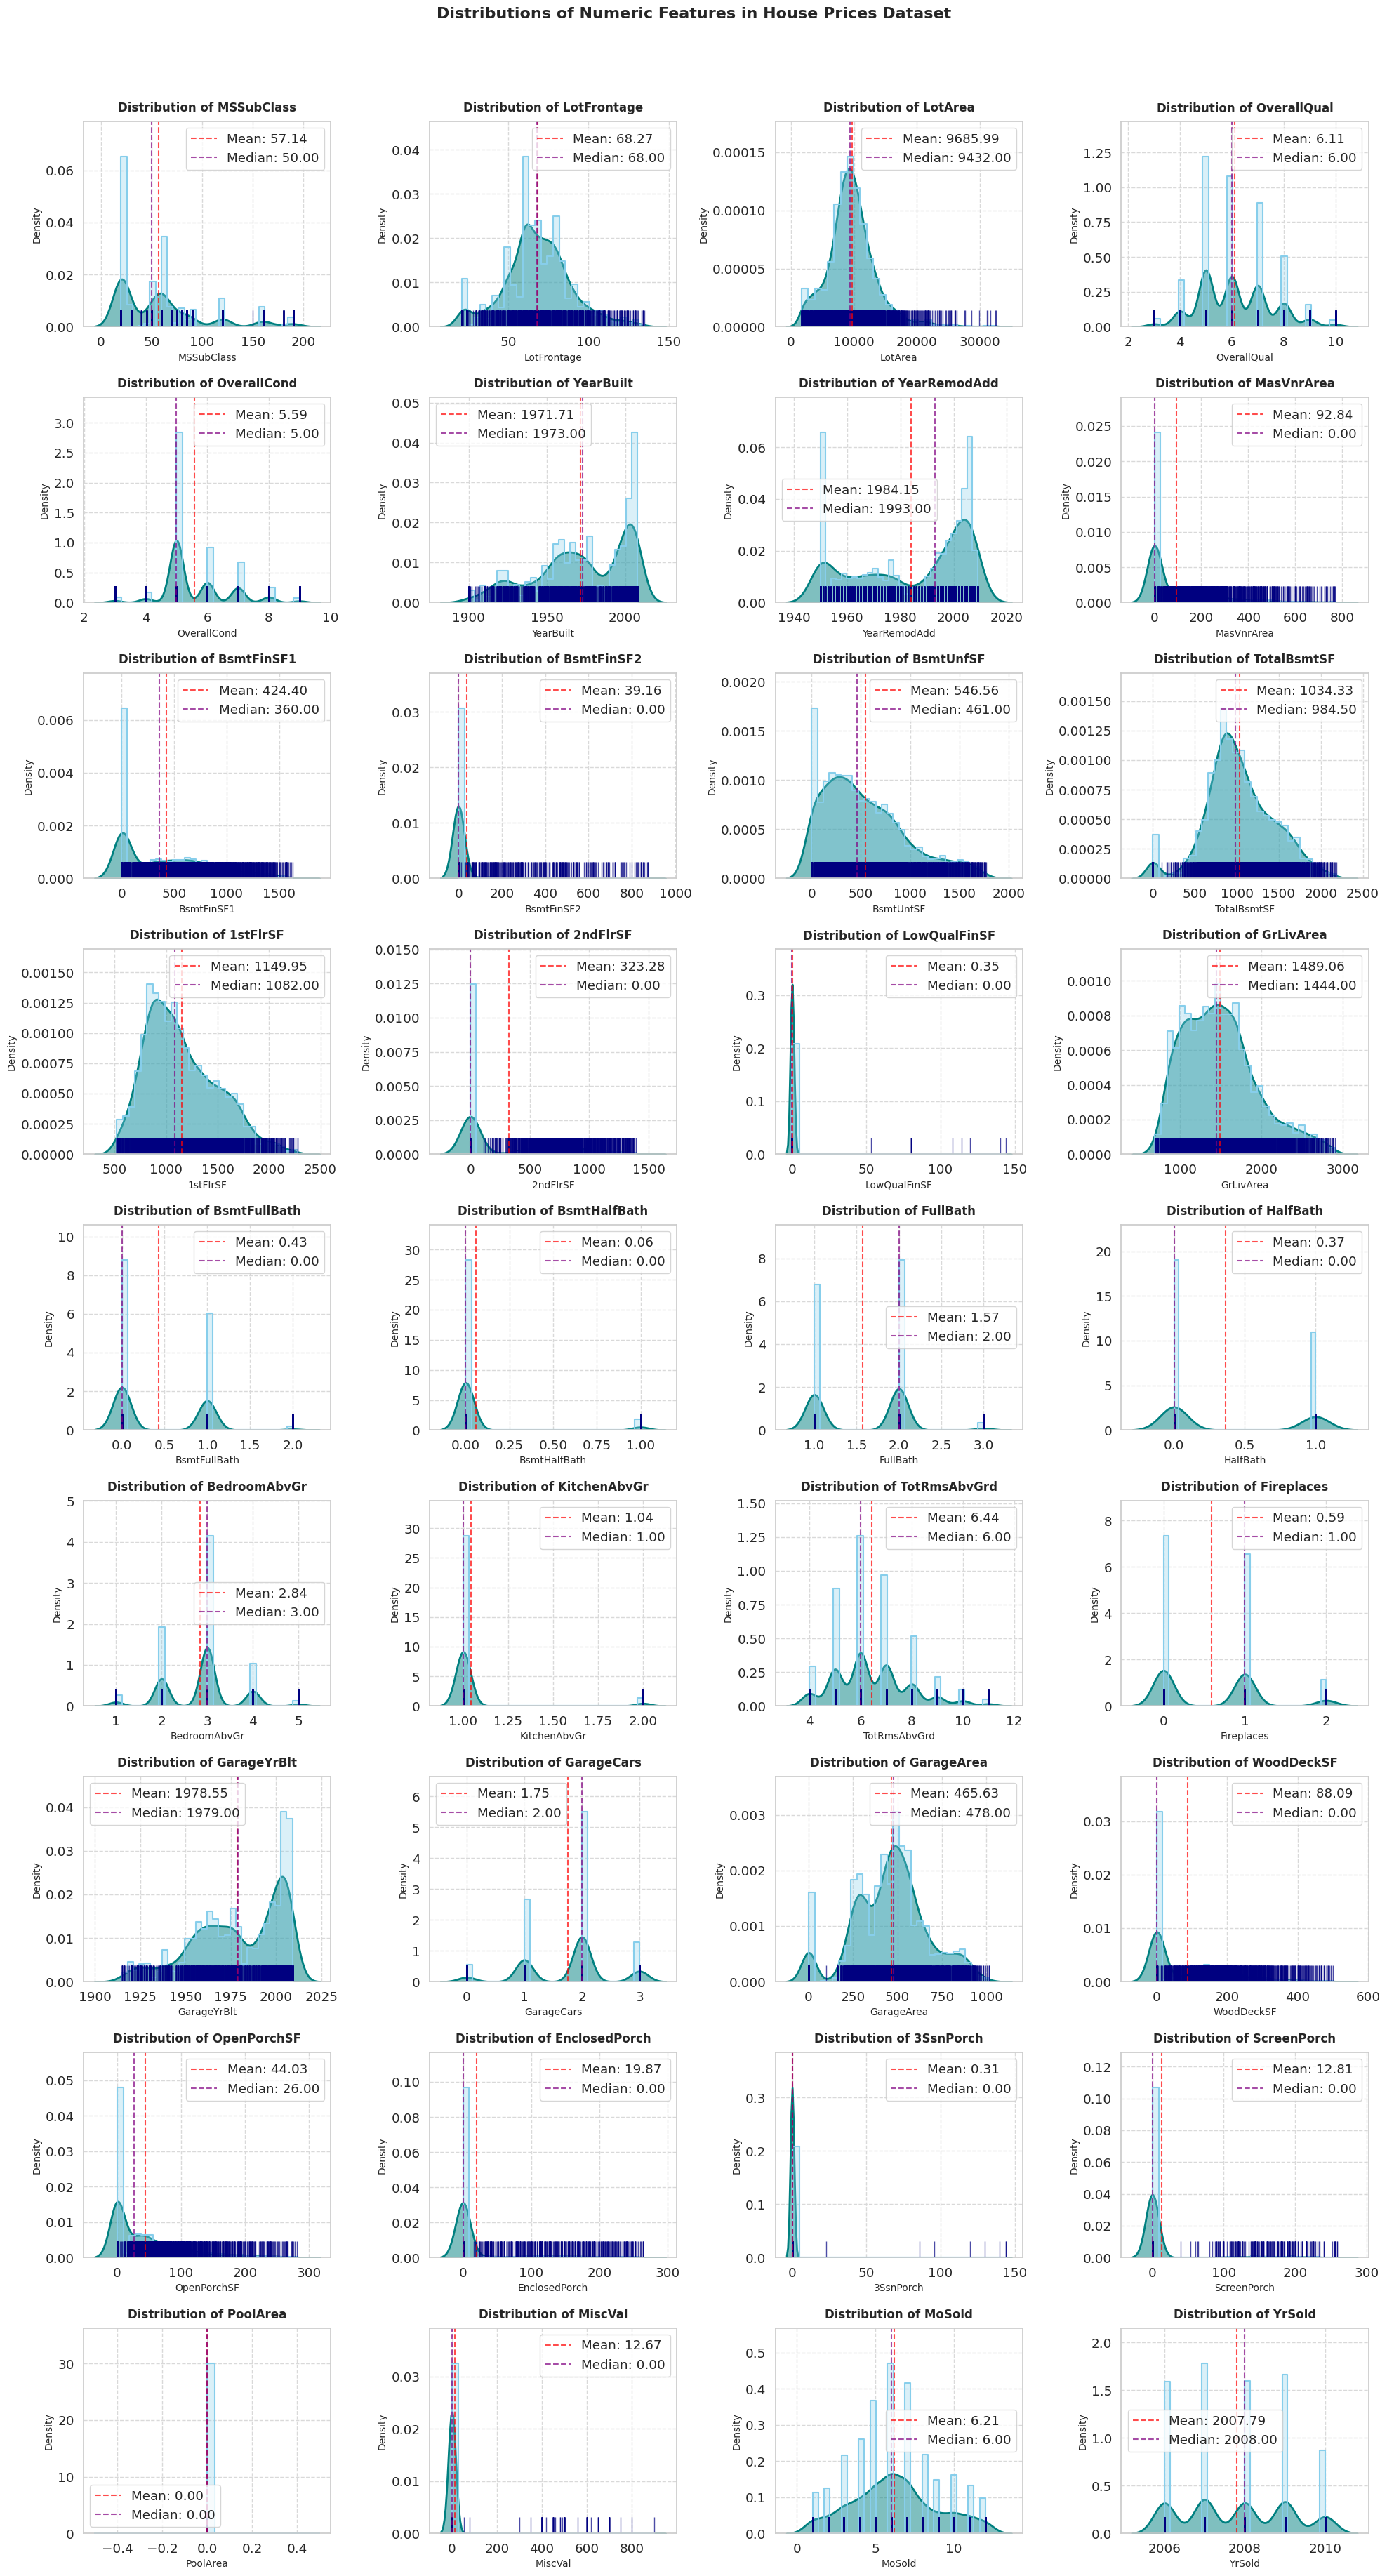

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
n_cols = len(numeric_cols)


nrows = (n_cols + 3) // 4
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(20, nrows * 4))
axes = axes.flatten()

for idx, column in enumerate(numeric_cols):
    q_low, q_high = df[column].quantile([0.01, 0.99])
    filtered_data = df[column][(df[column] >= q_low) & (df[column] <= q_high)]

    sns.kdeplot(
        data=filtered_data,
        ax=axes[idx],
        fill=True,
        color="teal",
        alpha=0.5,
        linewidth=2,
    )


    sns.histplot(
        data=filtered_data,
        ax=axes[idx],
        stat="density",
        color="skyblue",
        alpha=0.3,
        bins=30,
        element="step",
        linewidth=1.5,
    )


    sns.rugplot(
        data=filtered_data,
        ax=axes[idx],
        alpha=0.7,
        height=0.08,
        color="navy",
    )

    # Додавання вертикальних ліній для середнього та медіани
    mean_val = filtered_data.mean()
    median_val = filtered_data.median()
    axes[idx].axvline(mean_val, color="red", linestyle="--", alpha=0.7, label=f"Mean: {mean_val:.2f}")
    axes[idx].axvline(median_val, color="purple", linestyle="--", alpha=0.7, label=f"Median: {median_val:.2f}")


    axes[idx].set_title(f"Distribution of {column}", fontsize=12, weight="bold", pad=10)
    axes[idx].set_xlabel(column, fontsize=10)
    axes[idx].set_ylabel("Density", fontsize=10)
    axes[idx].legend()

# Видалення порожніх підграфіків, якщо вони є
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Distributions of Numeric Features in House Prices Dataset", fontsize=16, weight="bold", y=1.02)
plt.tight_layout()

In [ ]:
for i in ["LotArea",'LotFrontage','GrLivArea','1stFlrSF']:
  train_df[f"{i}_log"] = np.log1p(train_df[i])
  test_df[f"{i}_log"] = np.log1p(test_df[i])

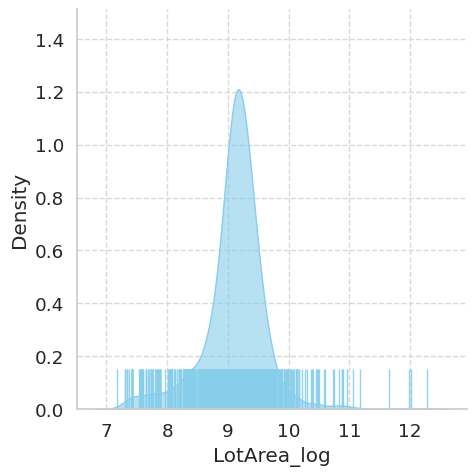

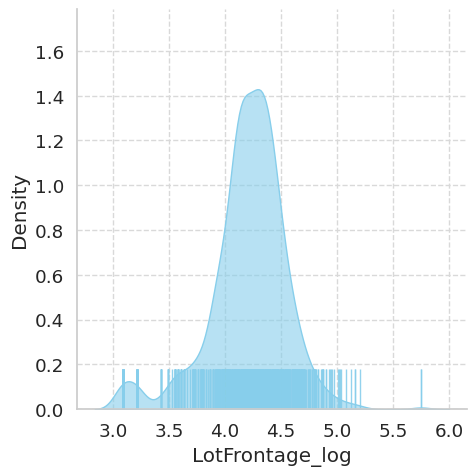

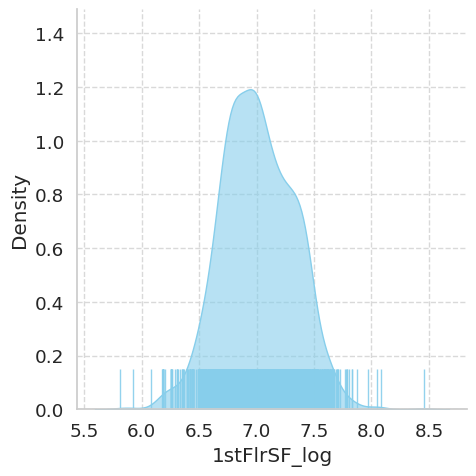

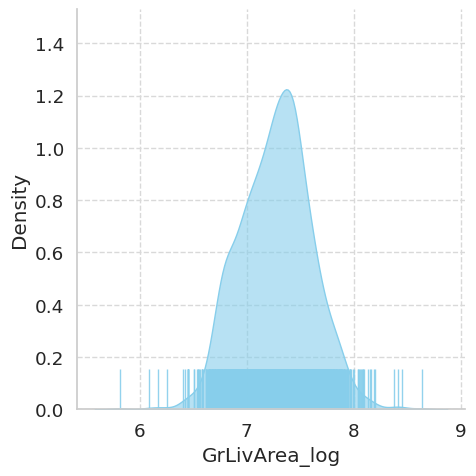

In [ ]:
for col in ['LotArea_log','LotFrontage_log','1stFlrSF_log','GrLivArea_log']:
  sns.displot(train_df[col],
              kind="kde",
              fill=True,
              rug=True,
              rug_kws={"alpha": 0.9, "height": 0.1},
              color="skyblue",
              alpha=0.6,)
  plt.show()

In [ ]:
train_df.drop(['GrLivArea','1stFlrSF','LotFrontage','LotArea'],axis=1,inplace=True)
test_df.drop(['GrLivArea','1stFlrSF','LotFrontage','LotArea'],axis=1,inplace=True)

# Correlation and multicollinearity analysis

We build a heat map of correlations to visualize the relationships between numerical features and the target variable SalePrice. We pay particular attention to:

    Features that strongly correlate with SalePrice, as they are the most important for modeling.
Features that strongly correlate with each other (multicollinearity). This can destabilize the model. We identify pairs of features with a correlation above the threshold (0.8) and remove one of them.

Top correlated features with SalePrice:
 SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


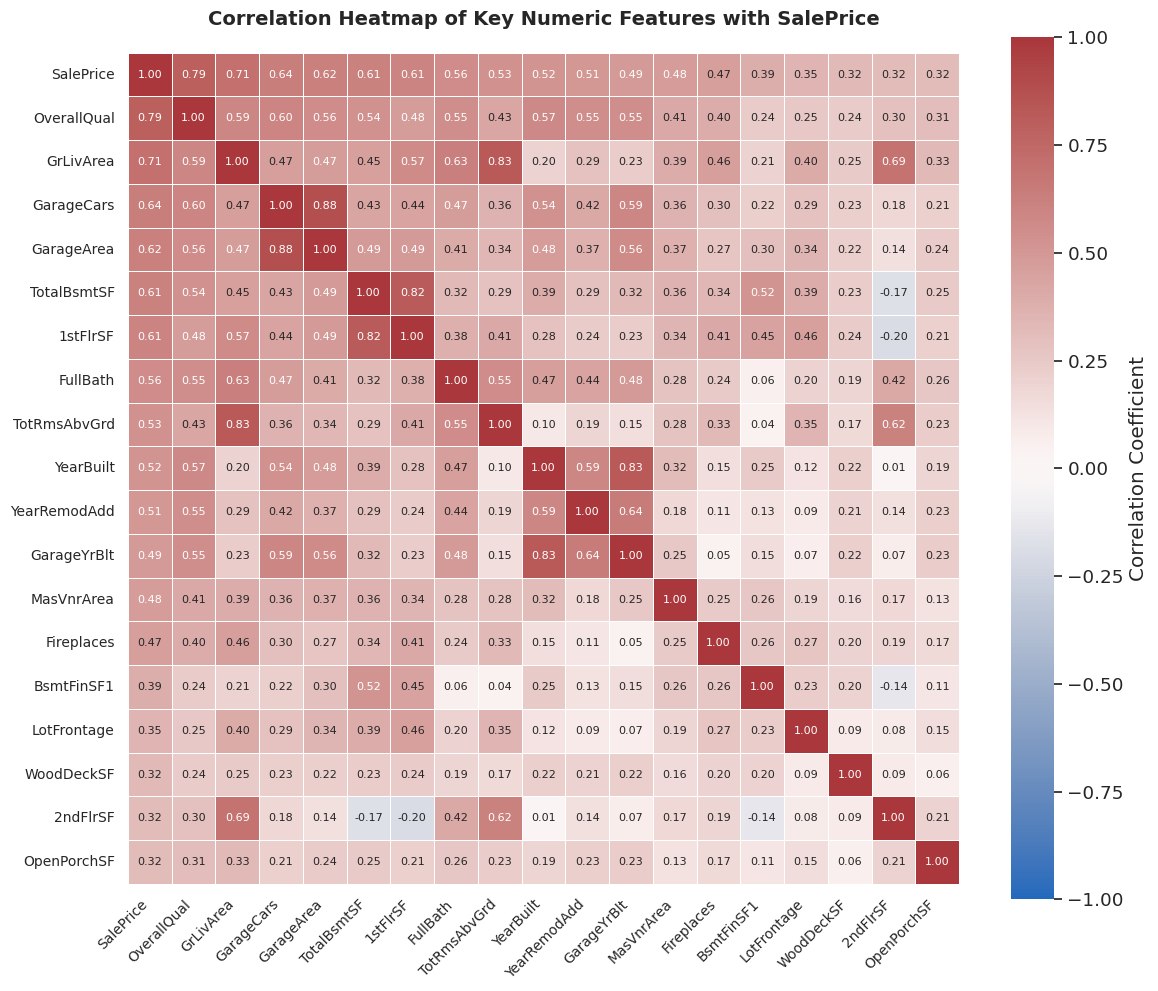

In [ ]:
corr = train_with_saleprice.select_dtypes(include=['float64', 'int64']).corr()

# Вибір стовпців із кореляцією з SalePrice більше |0.3|
corr_saleprice = corr['SalePrice'].abs().sort_values(ascending=False)
selected_cols = corr_saleprice[corr_saleprice > 0.3].index
corr_filtered = corr.loc[selected_cols, selected_cols]


n_cols = len(selected_cols)
fig_size = min(12, max(8, n_cols))
plt.figure(figsize=(fig_size, fig_size))

sns.heatmap(
    corr_filtered,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    square=True,
    cbar_kws={"shrink": 0.75, "label": "Correlation Coefficient"},
    annot_kws={"size": 8},
    linewidths=0.5,
    linecolor="white",
    vmin=-1, vmax=1,
)

plt.title("Correlation Heatmap of Key Numeric Features with SalePrice", fontsize=14, weight="bold", pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

print("Top correlated features with SalePrice:\n", corr_saleprice.head(10))

plt.show()

In [ ]:
threshold = 0.8
to_drop = set()

for i in range(len(corr.columns)):
  for j in range(i+1,len(corr.columns)):
    if abs(corr.iloc[i,j]) >= threshold:

      to_drop.add(corr.columns[i])

In [ ]:
to_drop

{'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt'}

In [ ]:
train_df.drop(['TotRmsAbvGrd','GarageYrBlt'],axis=1,inplace=True)
test_df.drop(['TotRmsAbvGrd','GarageYrBlt'],axis=1,inplace=True)

# Analysis of categorical characteristics

Using box plots, we analyze how each categorical feature affects the target variable. The graphs are sorted by the median value of SalePrice, which makes it easier to see trends and identify the most influential categories.

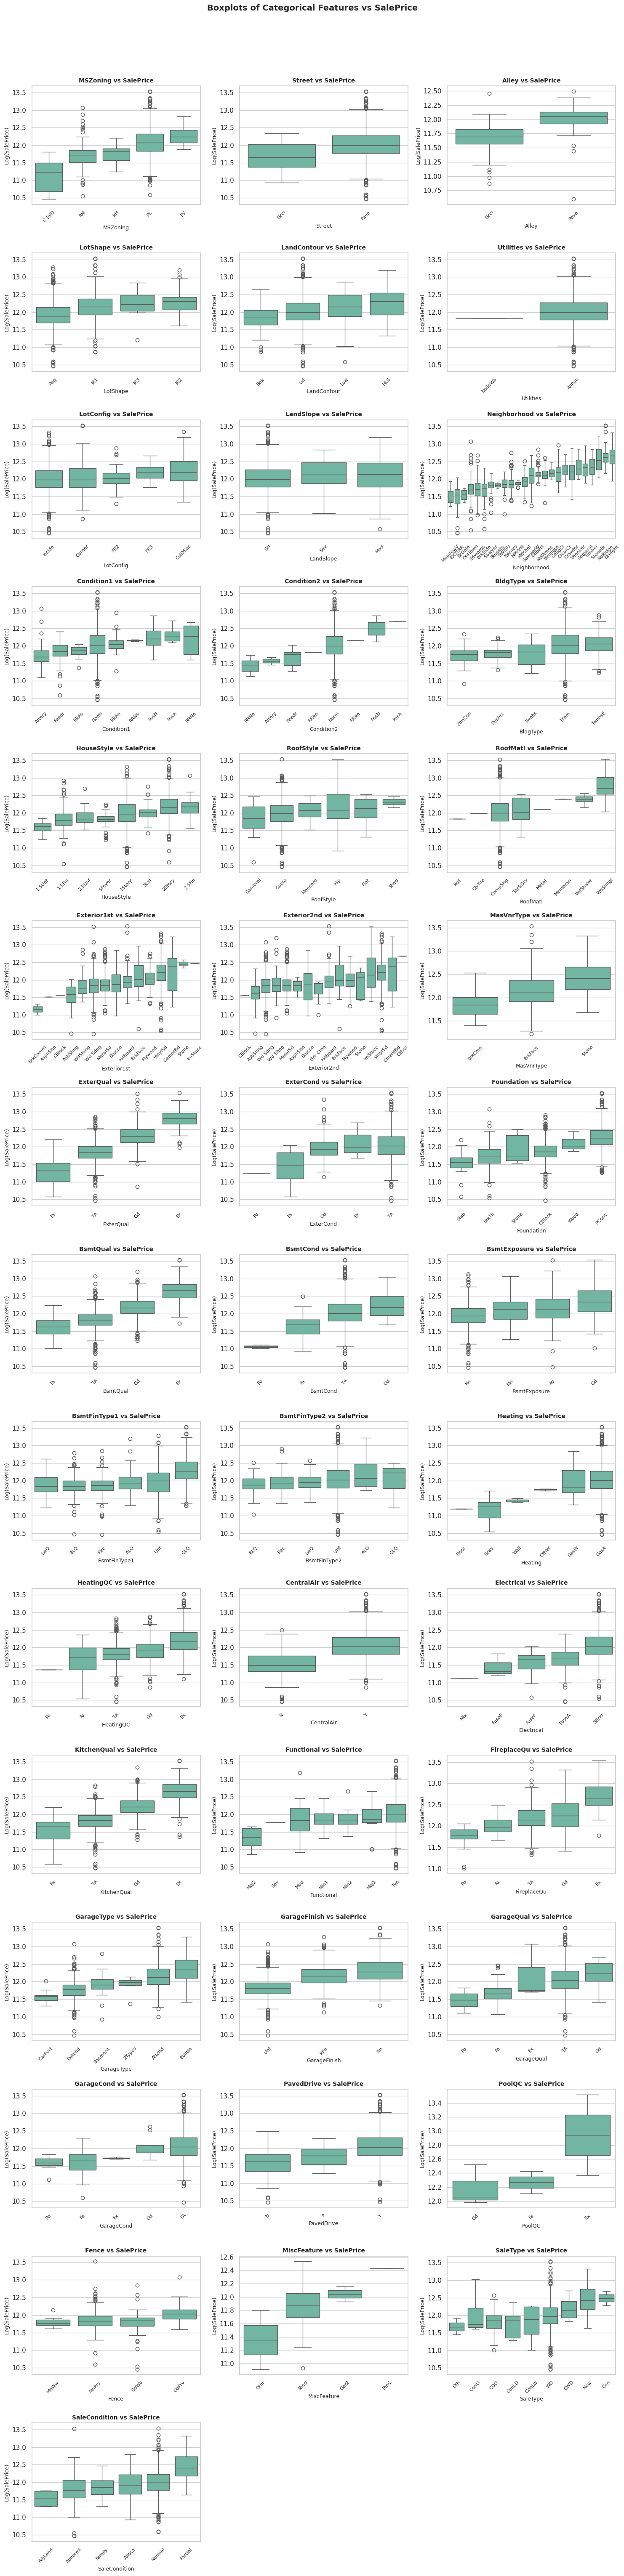

In [ ]:
sns.set_theme(style="whitegrid", palette="Set2", context="notebook", font_scale=1)

categorical = train_df.select_dtypes(include='object').columns

nrows = (len(categorical) + 2) // 3
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows * 4))
axes = axes.flatten()

for idx, cat in enumerate(categorical):
    sns.boxplot(x=train_df[cat], y=y, ax=axes[idx], order=train_with_saleprice.groupby(cat)['SalePrice'].median().sort_values().index)
    axes[idx].set_title(f"{cat} vs SalePrice", fontsize=10, weight="bold")
    axes[idx].set_xlabel(cat, fontsize=9)
    axes[idx].set_ylabel("Log(SalePrice)" if y.min() > 0 else "SalePrice", fontsize=9)
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)

# Видалення порожніх підграфіків
for idx in range(len(categorical), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Boxplots of Categorical Features vs SalePrice", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

Selection and removal of low-informative categorical features

Not all categorical features are equally useful. We perform analysis to find candidates for removal based on the following criteria:

Too many categories: Complicates modeling.

Low median variation: The feature has little effect on SalePrice.

Imbalance: One category accounts for more than 90% of the data.

In [ ]:
category_impact = {}
to_remove = []

# Порогове значення для варіації медіан
threshold_var = 0.05 * y.std()

for col in categorical:
    nunique = train_df[col].nunique()

    if nunique <= 20:
        # Варіація медіан по категоріях
        medians = train_with_saleprice.groupby(col)["SalePrice"].median()
        variation = medians.var()
        category_impact[col] = variation

        # Перевірка на шум або незбалансованість
        value_counts = train_df[col].value_counts(normalize=True)
        if variation < threshold_var:
            reason = f"🟡 Low variation of medians: {variation:.0f}"
            to_remove.append((col, reason))
        elif value_counts.iloc[0] > 0.9:
            reason = f"🟠 Unbalanced — top category covers {value_counts.iloc[0]*100:.1f}%"
            to_remove.append((col, reason))
    else:
        reason = f"🔴 Too many categories: {nunique}"
        to_remove.append((col, reason))

# Формування датафрейму з варіацією медіан по фічах
impact_df = pd.DataFrame(category_impact.items(), columns=["Feature", "MedianVar"])
impact_df = impact_df.sort_values(by="MedianVar", ascending=False)
impact_df["MedianVar"] = impact_df["MedianVar"].round(4)

print("\n🔍 Ранжування фіч за варіацією медіан SalePrice:\n")
print(impact_df)

print("\n🧹 Фічі-кандидати на видалення:\n")
for col, reason in to_remove:
    print(f"{col:<20} | {reason}")



🔍 Ранжування фіч за варіацією медіан SalePrice:

          Feature     MedianVar
37         PoolQC  2.984858e+10
17      ExterQual  1.500557e+10
20       BsmtQual  8.480353e+09
29    KitchenQual  8.201256e+09
9      Condition2  7.047457e+09
31    FireplaceQu  4.928304e+09
39    MiscFeature  4.246557e+09
13       RoofMatl  4.212000e+09
14    Exterior1st  3.362615e+09
21       BsmtCond  3.226504e+09
40       SaleType  2.985848e+09
16     MasVnrType  2.954671e+09
15    Exterior2nd  2.756294e+09
0        MSZoning  2.533712e+09
27     CentralAir  2.450000e+09
41  SaleCondition  2.307027e+09
34     GarageQual  2.071188e+09
32     GarageType  1.791800e+09
18      ExterCond  1.710923e+09
33   GarageFinish  1.675000e+09
28     Electrical  1.594762e+09
26      HeatingQC  1.557543e+09
2           Alley  1.404500e+09
25        Heating  1.308219e+09
19     Foundation  1.274425e+09
4     LandContour  1.272802e+09
1          Street  1.188281e+09
8      Condition1  1.150746e+09
3        LotShape  1.0

# Outliers detection

In [ ]:
def outliers_detect(train_df,col):
  q1 = train_df[col].quantile(0.25)
  q3 = train_df[col].quantile(0.75)
  iqr = q3-q1
  lower = q1-1.5*iqr
  upper = q3+1.5*iqr
  return train_df[(train_df[col] <= lower) | (train_df[col] >= upper)]

In [ ]:
out_indexes = []
for col in ['GrLivArea_log','1stFlrSF_log','LotFrontage_log','LotArea_log']:
    out_indexes.extend(outliers_detect(train_df, col).index)
out_indexes = np.unique(out_indexes).astype('int64')

In [ ]:
out_indexes.size

182

Занадто багато знайшло викидів,практично 10% від даних

In [ ]:
for col in train_df.select_dtypes(include=['int64','float64']):
    train_df[col] = winsorize(train_df[col], limits=[0.01, 0.01]) # найбільш екстремальні числові значення
                                                                  # будуть зглажені(замінює екстримальні значення на 1 і 99 персентиль)

In [ ]:
train_df

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotArea_log,LotFrontage_log,GrLivArea_log,1stFlrSF_log
0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,NaN,0,2,2008,WD,Normal,9.042040,4.189655,7.444833,6.753438
1,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,NaN,0,5,2007,WD,Normal,9.169623,4.394449,7.141245,7.141245
2,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,NaN,0,9,2008,WD,Normal,9.328212,4.234107,7.488294,6.825460
3,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,NaN,0,2,2006,WD,Abnorml,9.164401,4.110874,7.448916,6.869014
4,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,NaN,0,12,2008,WD,Normal,9.565284,4.442651,7.695758,7.044033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,NaN,0,8,2007,WD,Normal,8.976894,4.143135,7.407318,6.860664
1456,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,NaN,0,2,2010,WD,Normal,9.486152,4.454347,7.637234,7.637234
1457,70,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,Shed,700,5,2010,WD,Normal,9.109746,4.204693,7.758333,7.080868
1458,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,NaN,0,4,2010,WD,Normal,9.181735,4.234107,6.983790,6.983790


# Handling missing values (NaN)

We use a combined approach:

Filling in ‘None’: For categorical features where NaN makes sense (e.g., no basement or garage), we fill in the gaps with the string ‘None’.

KNNImputer: For numerical features, we use KNNImputer, which fills in gaps based on the values of the “nearest neighbors,” which is a more advanced method than simply filling in with the mean or median.

In [ ]:
train_df.isna().sum()[train_df.isna().sum()>0]

,0
Alley,1369
MasVnrType,872
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1
FireplaceQu,690
GarageType,81


In [ ]:
cols_with_meaningful_na = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                           'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                           'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature','MasVnrType','MasVnrArea','Electrical']
for col in cols_with_meaningful_na:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

In [ ]:
test_df.replace('None', np.nan, inplace=True)

/tmp/ipython-input-28-2668617629.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df.replace('None', np.nan, inplace=True)


In [ ]:
imputer = KNNImputer(n_neighbors=5)
numerical_cols = train_df.select_dtypes(include=['int64','float64']).columns
train_df[numerical_cols] = imputer.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = imputer.transform(test_df[numerical_cols])

# Feature Engineering

Based on existing data, I create new, more informative features. This can significantly improve the quality of the model, as new features may contain hidden dependencies.

In [ ]:
# Загальна кількість санвузлів
train_df['TotalBath'] = train_df['FullBath'] + 0.5 * train_df['HalfBath'] + train_df['BsmtFullBath'] + 0.5 * train_df['BsmtHalfBath']
test_df['TotalBath'] = test_df['FullBath'] + 0.5 * test_df['HalfBath'] + test_df['BsmtFullBath'] + 0.5 * test_df['BsmtHalfBath']

# Вік будинку на момент продажу
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']

# Кількість років з моменту реконструкції
train_df['YrsSinceRemod'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['YrsSinceRemod'] = test_df['YrSold'] - test_df['YearRemodAdd']

# Ознака наявності басейну/гаража
train_df['HasPool'] = train_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_df['HasPool'] = test_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_df['HasGarage'] = train_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test_df['HasGarage'] = test_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# Чи був будинок реконструйований
train_df['WasRemodeled'] = (train_df['YearRemodAdd'] != train_df['YearBuilt']).astype(int)
test_df['WasRemodeled'] = (test_df['YearRemodAdd'] != test_df['YearBuilt']).astype(int)

# Взаємодія якості та стану
train_df['OverallQualCond'] = train_df['OverallQual'] * train_df['OverallCond']
test_df['OverallQualCond'] = test_df['OverallQual'] * test_df['OverallCond']

In [ ]:
train_df = train_df.drop(['Street','Utilities','LandSlope','Condition2','RoofMatl','BsmtCond','Heating',
                          'CentralAir','Electrical','Functional','GarageQual','GarageCond','PavedDrive'],axis=1)
test_df = test_df.drop(['Street','Utilities','LandSlope','Condition2','RoofMatl','BsmtCond','Heating',
                          'CentralAir','Electrical','Functional','GarageQual','GarageCond','PavedDrive'],axis=1)

In [ ]:
train_df['HasPool'] = train_df['HasPool'].fillna(train_df['HasPool'].median())

In [ ]:
train_df.isna().sum()[train_df.isna().sum()>0]

,0


# Coding categorical features and column alignment

Machine learning models work with numbers, so text categorical features need to be converted. We use One-Hot Encoding (pd.get_dummies), which creates new binary columns for each category. After encoding, you need to make sure that the training and test sets have the same set of columns.

In [ ]:
categorical_cols = train_df.select_dtypes(include='object').columns
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True, dtype=int)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True, dtype=int)
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:

    test_df[col] = 0

test_df = test_df[train_df.columns]

In [ ]:
num_cols = test_df.select_dtypes(include=['int64', 'float64']).columns
test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].median())

cat_cols = test_df.select_dtypes(include='object').columns
for col in cat_cols:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

# Data scaling

Many algorithms (especially linear models and distance-based methods) are sensitive to feature scaling. I use RobustScaler, which is robust to outliers because it uses the median and interquartile range for scaling.

In [ ]:
scaler = RobustScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

In [ ]:
scaled_train_df = pd.DataFrame(scaled_train,columns = train_df.columns,index = train_df.index)
scaled_test_df = pd.DataFrame(scaled_test,columns = test_df.columns,index = test_df.index)

In [ ]:
scaled_train_df

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.2,0.5,0.0,0.652174,0.243243,1.166667,0.452790,0.0,-0.559829,-0.269652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.6,0.0,3.0,0.065217,-0.486486,0.000000,0.834679,0.0,-0.330769,0.538308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2,0.5,0.0,0.608696,0.216216,0.964286,0.143910,0.0,-0.074359,-0.142289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4,0.5,0.0,-1.260870,-0.648649,0.000000,-0.235170,0.0,0.106838,-0.468657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,0.2,1.0,0.0,0.586957,0.162162,2.083333,0.381186,0.0,0.021368,0.305473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.2,0.0,0.0,0.565217,0.162162,0.000000,-0.538435,0.0,0.812821,-0.076617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,-0.6,0.0,1.0,0.108696,-0.162162,0.708333,0.570727,163.0,0.190598,1.095522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,0.4,0.5,4.0,-0.695652,0.324324,0.000000,-0.152334,0.0,0.682906,0.319403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,-0.6,-0.5,1.0,-0.500000,0.054054,0.000000,-0.469638,841.0,-0.816239,0.172139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature selection based on importance

After all the transformations, I may end up with a large number of features. To reduce the dimensionality and remove “noise,” I use RandomForestRegressor to evaluate the importance of each feature. We retain only the top 150 most important features for further modeling.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(scaled_train_df, y)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 150  # залишити топ-50 ознак
top_features = scaled_train_df.columns[indices[:top_n]]

selected_train_df = scaled_train_df[top_features]
selected_test_df = scaled_test_df[top_features]

In [ ]:
selected_train_df

,OverallQual,GrLivArea_log,TotalBsmtSF,GarageCars,OverallQualCond,TotalBath,1stFlrSF_log,GarageArea,BsmtFinSF1,LotArea_log,...,Neighborhood_NridgHt,Exterior1st_CemntBd,Neighborhood_MeadowV,Condition1_RRAn,Exterior2nd_BrkFace,RoofStyle_Gambrel,Exterior1st_Stucco,MiscFeature_Shed,Exterior1st_WdShing,Neighborhood_Gilbert
0,0.5,0.342891,-0.269652,0.0,0.0,3.0,-0.524119,0.281573,0.452790,-0.267660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.327743,0.538308,0.0,1.3,1.0,0.327547,-0.082816,0.834679,0.029682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.438896,-0.142289,0.0,0.0,3.0,-0.365950,0.530021,0.143910,0.399288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,0.351910,-0.468657,1.0,0.0,0.0,-0.270300,0.670807,-0.235170,0.017513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.897190,0.305473,1.0,0.5,3.0,0.114059,1.474120,0.381186,0.951802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.260018,-0.076617,0.0,-0.5,1.0,-0.288639,-0.082816,-0.538435,-0.419488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1456,0.0,0.767910,1.095522,0.0,0.1,2.0,1.416793,0.082816,0.570727,0.767380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,0.5,1.035420,0.319403,-1.0,2.8,0.0,0.194953,-0.944099,-0.152334,-0.109865,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1458,-0.5,-0.675565,0.172139,-1.0,-0.5,0.0,-0.018241,-0.993789,-0.469638,0.057911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Hyperparameter selection using Optuna



In [ ]:
# --- Функція для RandomForest ---
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42, 'n_jobs': -1
    }
    model = RandomForestRegressor(**params)
    score = cross_val_score(model, selected_train_df, y, cv=5, scoring='neg_root_mean_squared_error')
    return -score.mean()

# --- Функція для Ridge ---
def objective_ridge(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-3, 100)
    model = Ridge(alpha=alpha, random_state=42)
    score = cross_val_score(model, selected_train_df, y, cv=5, scoring='neg_root_mean_squared_error')
    return -score.mean()

# --- Функція для CatBoost ---
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000), 'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2), 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1), 'random_seed': 42, 'loss_function': 'RMSE', 'verbose': 0
    }
    model = CatBoostRegressor(**params)
    score = cross_val_score(model, selected_train_df, y, cv=5, scoring='neg_root_mean_squared_error')
    return -score.mean()

# --- Функція для XGBoost ---
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 800), 'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2), 'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), 'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1), 'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), 'objective': 'reg:squarederror',
        'tree_method': 'hist', 'random_state': 42
    }
    model = XGBRegressor(**params)
    score = cross_val_score(model, selected_train_df, y, cv=5, scoring='neg_root_mean_squared_error')
    return -score.mean()

# --- Функція для ElasticNet ---
def objective_elasticnet(trial):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'random_state': 42
    }
    model = ElasticNet(**params)
    score = cross_val_score(model, selected_train_df, y, cv=5, scoring='neg_root_mean_squared_error')
    return -score.mean()



study_rf = optuna.create_study(direction='minimize');
study_rf.optimize(objective_rf, n_trials=100)
study_ridge = optuna.create_study(direction='minimize');
study_ridge.optimize(objective_ridge, n_trials=100)
study_cat = optuna.create_study(direction='minimize');
study_cat.optimize(objective_cat, n_trials=100)
study_xgb = optuna.create_study(direction='minimize');
study_xgb.optimize(objective_xgb, n_trials=150)
study_en = optuna.create_study(direction='minimize');
study_en.optimize(objective_elasticnet, n_trials=200)

[I 2025-06-24 12:02:54,545] A new study created in memory with name: no-name-51dc3a16-4079-43a7-bf54-45804c1ec02e
[I 2025-06-24 12:02:58,485] Trial 0 finished with value: 0.1472416474552644 and parameters: {'n_estimators': 218, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.1472416474552644.
[I 2025-06-24 12:03:23,653] Trial 1 finished with value: 0.14660019730829213 and parameters: {'n_estimators': 649, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.14660019730829213.
[I 2025-06-24 12:03:35,584] Trial 2 finished with value: 0.14558206743381472 and parameters: {'n_estimators': 233, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.14558206743381472.
[I 2025-06-24 12:04:11,211] Trial 3 finished with value: 0.14070956555369446 and parameters: {'n_estimators': 906, 'max_depth': 

In [ ]:
best_params = {
    'rf': study_rf.best_params,
    'ridge': study_ridge.best_params,
    'cat': study_cat.best_params,
    'xgb': study_xgb.best_params,
    'elasticnet': study_en.best_params
}

In [ ]:
rf_best = RandomForestRegressor(**best_params['rf'], random_state=42, n_jobs=-1)
ridge_best = Ridge(**best_params['ridge'], random_state=42)
catboost_best = CatBoostRegressor(**best_params['cat'], loss_function='RMSE', random_seed=42, verbose=0)
xgb_best = XGBRegressor(**best_params['xgb'], objective='reg:squarederror', tree_method='hist', random_state=42)
elasticnet_best = ElasticNet(**best_params['elasticnet'], random_state=42)


In [ ]:
from lightgbm import LGBMRegressor
model_lgb = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_best),
        ('cat', catboost_best),
        ('rf', rf_best),
        ('lgbm',model_lgb),
        ('elastic',elasticnet_best)
    ],
    final_estimator=ridge_best,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

In [ ]:
stack_model.fit(selected_train_df, y)
preds_stack = stack_model.predict(selected_test_df)

catboost_best.fit(selected_train_df, y)
preds_cat = catboost_best.predict(selected_test_df)


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [ ]:
xgb_best.fit(selected_train_df, y)
preds_xgb = catboost_best.predict(selected_test_df)

In [ ]:
final_preds = (0.5 * preds_stack + 0.5 * preds_cat)

In [ ]:
final_preds

array([ 57132.4332651 ,  58759.70866438,  90694.50456597, ...,
        86618.68399518,  60195.36302102, 111215.21616072])

In [ ]:
final_preds_total = np.expm1(final_preds)

In [ ]:
final_preds_total

array([132028.87611116, 162520.0662642 , 186332.40207175, ...,
       157952.41713631, 119426.46561905, 229710.0032223 ])

In [ ]:
submission = pd.DataFrame({
    'Id': test_id,
    'SalePrice': final_preds_total
})

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
final_preds

array([inf, inf, inf, ..., inf, inf, inf])

In [ ]:
best_params = {
    'rf': study_rf.best_params,
    'ridge': study_ridge.best_params,
    'cat': study_cat.best_params,
    'xgb': study_xgb.best_params,
    'elastic' : study_en.best_params
}

with open('best_params.json', 'w') as f:
    json.dump(best_params, f)

In [ ]:
with open('best_params.json', 'r') as f:
    best_params = json.load(f)

rf_best = RandomForestRegressor(**best_params['rf'], random_state=42)
ridge_best = Ridge(**best_params['ridge'], random_state=42)
catboost_best = CatBoostRegressor(**best_params['cat'], loss_function='RMSE', random_seed=42, verbose=0)
xgb_best = XGBRegressor(**best_params['xgb'], objective='reg:squarederror', tree_method='hist', random_state=42)
elasticnet_best = ElasticNet(**best_params['elastic'], random_state=42)
model_lgb = LGBMRegressor(**best_params['lgbm'], random_state=42)